# Finding discords of any length in a time series

This tutorial explains the MERLIN algorithm proposed in [MERLIN](https://www.cs.ucr.edu/~eamonn/MERLIN_Long_version_for_website.pdf). 

You can find the support webpage here: [MERLIN: SUPPORT](https://sites.google.com/view/merlin-find-anomalies).

The algorithm provides the discords of arbitrary length in time series.

## import libraries

In [1]:
%matplotlib inline

import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('stumpy.mplstyle')

## import toy data set: noisy sine wave

In [2]:
from scipy.io import loadmat

# data set is available at: 
# https://drive.google.com/file/d/1cDkZVKYse_E0_fGZqTRQZrrMBRFrR2Mv/view

data = loadmat("MERLIN_datasets\\NoisySine.mat") 
ts = data['T'].reshape(-1,)

## Visualizing data

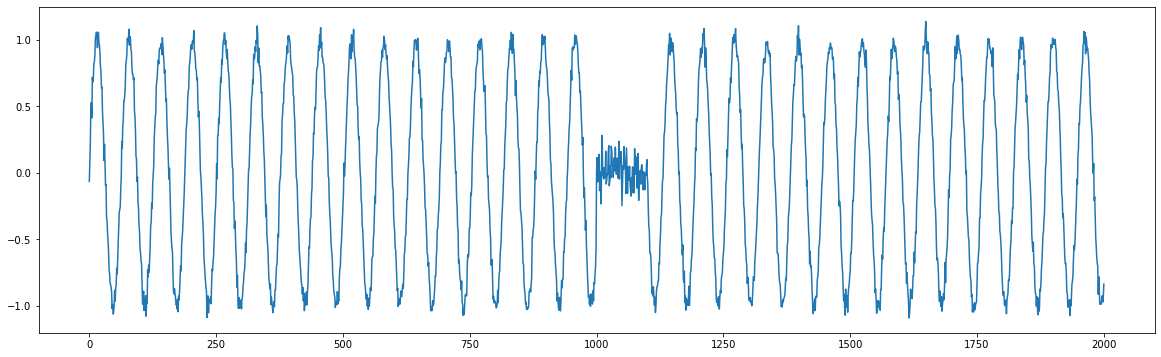

In [3]:
plt.plot(ts)
plt.show()

As depicted in the figure above, there is an anomaly in the sequence

## implemeting MERLIN algorithm

### part I: DRAG algorithm 

DRAG algorithm is a name used by the authors to refer to the algorithm proposed in [](). The DRAG aglorithm tries to find a set of discords for a user-defined r (range of discord: the threshold. A subsequence is discord if its distance to its NN is not less than r.

In [4]:
def candidate_selection_algorithm(
    T, 
    m, 
    r
):
    """
    For a time series T, the algorithm finds a set of discords whose distance with their NN is more than r. 
    
    Parameters
    ---------
    T: ndarray
        the time series for which we try to find the discords
    
    m: int
        the length of the subsequence to consider in discovering the discords
    
    r: float
        the maximum distance allowed for non-discord subsquence to its NN subsequence 
        (threshold for discords' distance)
    
    
    output
    --------
    C: set
        a set of discords
    
    """
    z_normalize = True
    
    #create empty set
    C = set()
    
    #scan all subsequences
    for i in range(0,len(T)-m):
        is_candidate = True
        T_i = T[i:(i+m)]
        T_i = stumpy.core.z_norm(T_i)
        
        for j in C:
            if abs(i-j)>=m: #non-trival match test
                T_j = T[j:(j+m)]
                T_j = stumpy.core.z_norm(T_j)
                
                dist = np.linalg.norm(T_i-T_j)
                if dist < r:
                    is_candidate = False
                    break
        
        if is_candidate:
            C.add(i)
        else:
            C.remove(j)

            
    return C

In [5]:
T = ts[:]
m = 512 #one day as the length of subsequence
r = 10.27

C = candidate_selection_algorithm(T, m, r)
print('set C is: \n', C)

set C is: 
 {549, 550, 551, 552, 555, 556, 557, 558, 559, 560, 561, 562, 563, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 728, 731, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 796, 797, 798, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 81

In [6]:
def discords_refinement_algorithm(
    T, 
    m, 
    r, 
    C
):
    """
    For a time series T, the algorithm refines a set of discords by removing the false positives,
    i.e. the subsequences whose distance from their NN is more than r. 
    
    Parameters
    ---------
    T: ndarray
        the time series for which we try to find the discords
    
    m: int
        the length of the subsequence to consider in discovering the discords
    
    r: float
        the maximum distance allowed for non-discord subsquence to its NN subsequence 
        (threshold for discords' distance)
    
    C: set
        the set of indices of initially-discovered discored
    
    
    output
    --------
    discords: dataframe
        a dataframe where each row corresponds to a discovered discord 
        The columns are: ['Discord index', 'Discord NN index', 'NN distance']
        
    """
    C_list = list(C)
    
    D=np.empty(shape=(len(C_list),3)) #[discord index, discord NN index, NN dist]
    D[:,0] = C_list
    D[:,1] = -1
    D[:,2] = float('inf')
    
    _to_be_removed_idx = []
    
    
    for i in range(0, len(T)-m):
        if len(C_list)==0:
            print('The set C is empty. No discord discovered!')
            break
        
        is_discord = True
        T_i = stumpy.core.z_norm(T[i:(i+m)])
        
        for j_idx, j in enumerate(C_list):
            if j_idx not in _to_be_removed_idx:
                if abs(i-j)>=m:
                    T_j = stumpy.core.z_norm(T[j:(j+m)])

                    dist = np.linalg.norm(T_i-T_j)
                    if dist<r:
                        _to_be_removed_idx.append(j_idx)
                    else:
                        if dist<D[j_idx,2]:
                            D[j_idx,2] = dist
                            D[j_idx,1] = i
    
    D_pruned = np.delete(D, _to_be_removed_idx, axis=0)
    discords = pd.DataFrame(data = D_pruned, 
                  columns = ['Discord index', 'Discord NN index', 'NN distance'])
        
    return discords

In [7]:
discords = discords_refinement_algorithm(T, m, r, C)
discords

,Discord index,Discord NN index,NN distance
0,585.0,19.0,10.281380
1,586.0,20.0,10.305663
2,587.0,21.0,10.328111
3,588.0,22.0,10.345313
4,589.0,23.0,10.358682
...,...,...,...
303,1002.0,59.0,10.346239
304,1003.0,61.0,10.337979
305,1004.0,62.0,10.316143
306,1005.0,63.0,10.301214


In [8]:
discords_sorted = discords.sort_values(by ='NN distance', ascending=False, ignore_index=True)
discords_sorted

,Discord index,Discord NN index,NN distance
0,938.0,310.0,10.439015
1,939.0,311.0,10.437721
2,937.0,309.0,10.436094
3,844.0,1409.0,10.433220
4,940.0,312.0,10.433127
...,...,...,...
303,826.0,198.0,10.271512
304,632.0,4.0,10.271437
305,738.0,47.0,10.271434
306,895.0,1460.0,10.270160


#### PLOT the Top Discord

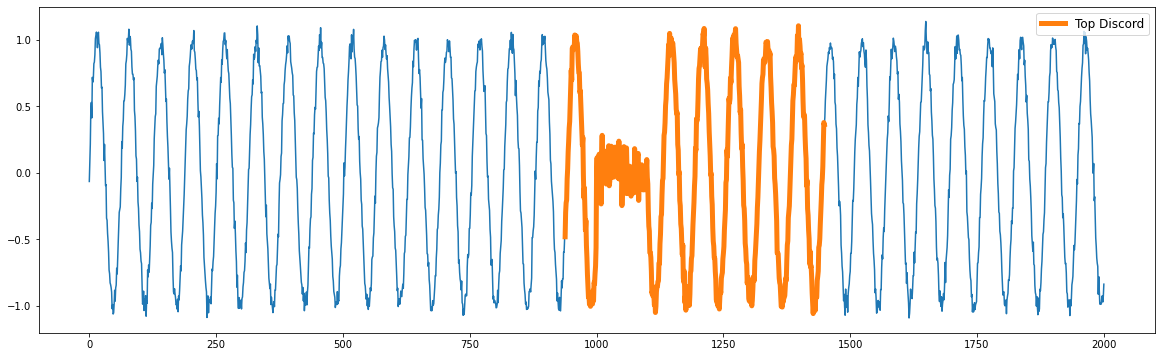

In [9]:
Top_Discord = discords_sorted.iloc[0,:]
Top_Discord_idx = int(Top_Discord[0])

plt.plot(ts)
plt.plot(np.arange(Top_Discord_idx,Top_Discord_idx+m),ts[Top_Discord_idx:Top_Discord_idx+m], lw=5, label='Top Discord')
plt.legend(fontsize=12)
plt.show()

In [10]:
#reproduce result of paper
discords_idx_sorted = discords.sort_values(by ='Discord index', ascending=True)
discords_idx_sorted

,Discord index,Discord NN index,NN distance
0,585.0,19.0,10.281380
1,586.0,20.0,10.305663
2,587.0,21.0,10.328111
3,588.0,22.0,10.345313
4,589.0,23.0,10.358682
...,...,...,...
303,1002.0,59.0,10.346239
304,1003.0,61.0,10.337979
305,1004.0,62.0,10.316143
306,1005.0,63.0,10.301214


### DRAG algorithm:

Let's combine the first two algorithm to only return the first discorc

In [11]:
def DRAG(T,m,r):
    """
    For a time series T, the algorithm finds a set of discords whose distance with their NN is more than r. 
    
    Parameters
    ---------
    T: ndarray
        the time series for which we try to find the discords
    
    m: int
        the length of the subsequence to consider in discovering the discords
    
    r: float
        the maximum distance allowed for non-discord subsquence to its NN subsequence 
        (threshold for discords' distance)
    
    
    output
    --------
    idx: index of top discord
    idx_NN: index of NN of top discord
    dist: dist between top discor and its NN  
    """
    
    #initializing output
    idx = -1; idx_NN = -1; dist = -1
    
    C = candidate_selection_algorithm(T, m, r) 
    
    if len(C)>0:
        discords = discords_refinement_algorithm(T, m, r, C)
        
        if len(discords['NN distance'])>0:
            top_discord = discords['NN distance'].argmax()
            idx = int(discords.iloc[top_discord, 0])
            idx_NN = int(discords.iloc[top_discord, 1])
            dist = discords.iloc[top_discord, 2] 

    return idx, idx_NN, dist

In [12]:
TopDiscord_idx, TopDiscord_idx_NN, TopDiscord_dist = DRAG(T,m,r) 

print("TopDiscord_idx: ", TopDiscord_idx)
print("TopDiscord_idx_NN: ", TopDiscord_idx_NN)
print("TopDiscord_dist: ", TopDiscord_dist)

TopDiscord_idx:  938
TopDiscord_idx_NN:  310
TopDiscord_dist:  10.439014925343344


### part II: MERLIN algorithm 

After the implementation of DRAG algorithm, we are at the position where we can start to implement MERLIN algorithm:

In [13]:
def MERLIN(T, MinL, MaxL):
    """
    For a time series T, the algorithm finds discords with length between MinL and MaxL. 
    
    Parameters
    ---------
    T: ndarray
        the time series for which we try to find the discords
    
    MinL: int
        subsequence length lower bound
    
    MaxL: int
        subsequence length upper bound
    
    
    output
    --------
    Discords : ndarray
        a two dimentional array where the axis 0 contains different discords and axis 1 has the information 
        of discord: 
        first column is the starting index of the discord subsequence
        second column is the length of the discord
        third column is the NN index
        fourth column is the distance of the discord to its NN
    
    """
    Discords = np.empty(shape = (0, 4), dtype='object') #Alternatively: Create np array with nrows=MaxL-MinL+1
    
    
    # Calculate the first discord of length MinL
    print('Stage#1: Calculating the first discord...')
    m = MinL
    r = 2 * (m ** 0.5)
    dist = -1
    while dist < 0:
        idx, idx_NN, dist = DRAG(T, m, r)
        r = r / 2
    
    new_discord = [idx, m, idx_NN, dist]
    Discords = np.vstack((Discords, new_discord))
    print('Discords after finding the first one: \n', new_discord)
    
    
    # Calculate next four discords (for the next four subsequent length)
    print('Stage#2: Calculating the next four discords...')
    dist_old = dist # we need the dist of the previous discord to modify r
    for m in range(MinL+1,MinL+5): 
        r = 0.99 * dist_old 
        
        dist = -1
        while dist < 0:
            idx, idx_NN, dist = DRAG(T, m, r)
            r = 0.99 * r
            
        new_discord = [idx, m, idx_NN, dist]
        Discords = np.vstack((Discords, new_discord))
        dist_old = dist
        print('>>> Discords after finding the next four discords: ', new_discord)
    
    
    # Calculate the remaining discords
    print('Stage#3: Calculating the remaining discords...')
    for m in range(MinL+5,MaxL+1): #what if MinL+5 > MaxL+1 ? (we need to consider such scenarios)
        mu_dist = np.mean(Discords[-5:, 3]) # calculating the mean of distance of the last 5 discovered discords 
        std_dist = np.std(Discords[-5:, 3]) # calculating the std of distance of the last 5 discovered discords
        
        r = mu_dist - 2 * std_dist
        
        dist = -1
        while dist < 0:
            idx, idx_NN, dist = DRAG(T, m, r)
            r = r - std_dist
        
        new_discord = [idx, m, idx_NN, dist]
        Discords = np.vstack((Discords, new_discord))
        print('>>> new discord: ', new_discord)
    
    
    return Discords

## Let's use MERLIN on TAXI data (Fig. 11)

In [17]:
#read data
df_taxi = pd.read_csv("MERLIN_datasets\\NAB_NYC_TAXI\\data\\realKnownCause\\nyc_taxi.csv") 
df_taxi = df_taxi.set_index(['timestamp'])

#select the range of dates considered in the paper
data =  df_taxi.loc['2014-10-01 00:00:00' : '2014-12-15 23:00:00']
data

,value
timestamp,
2014-10-01 00:00:00,12751
2014-10-01 00:30:00,8767
2014-10-01 01:00:00,7005
2014-10-01 01:30:00,5257
2014-10-01 02:00:00,4189
...,...
2014-12-15 21:00:00,21393
2014-12-15 21:30:00,21577
2014-12-15 22:00:00,21019


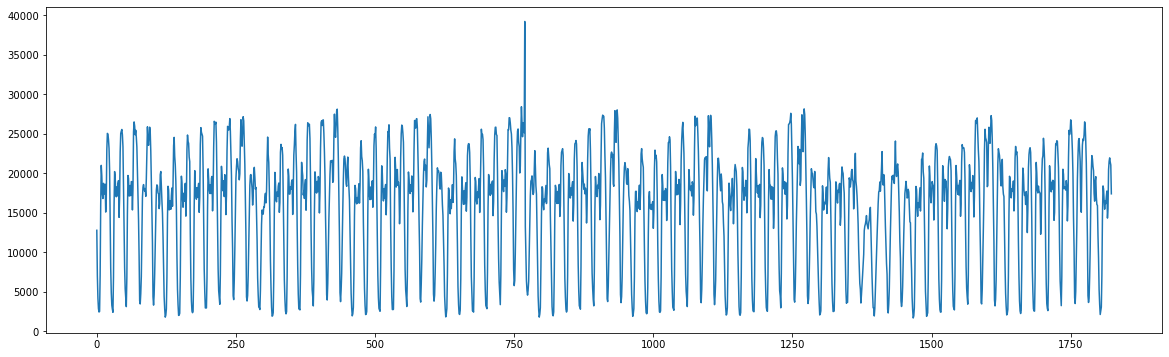

In [18]:
ts = np.reshape(data.to_numpy(),newshape=(-1,))
#let's consider only the data at each hour (not the half hours)
ts = [val for i,val in enumerate(ts) if i % 2 == 0]
ts = np.asarray(ts)

#to use it later in  MATLAB 
np.savetxt("taxi_to_reproduce_paper.csv.csv", ts, delimiter=",")

#plottting
plt.plot(ts)
plt.show()

In [19]:
np.set_printoptions(suppress=True)
Discords = MERLIN(ts, 5, 96)

Stage#1: Calculating the first discord...
Discords after finding the first one: 
 [1690, 5, 1120, 1.3642079150627304]
Stage#2: Calculating the next four discords...
>>> Discords after finding the next four discords:  [1522, 6, 1100, 1.4064712539239808]
>>> Discords after finding the next four discords:  [537, 7, 1689, 1.62928107746437]
>>> Discords after finding the next four discords:  [1380, 8, 443, 1.746810126819628]
>>> Discords after finding the next four discords:  [762, 9, 1328, 2.0634858945465493]
Stage#3: Calculating the remaining discords...
>>> new discord:  [761, 10, 1327, 2.1247537919540944]
>>> new discord:  [760, 11, 1381, 2.629462897528745]
>>> new discord:  [759, 12, 1380, 2.746225055671875]
>>> new discord:  [758, 13, 1379, 2.9819137944892202]
>>> new discord:  [757, 14, 1261, 3.5977491081910626]
>>> new discord:  [756, 15, 1260, 3.7262163688495025]
>>> new discord:  [755, 16, 1259, 3.8542112273477858]
>>> new discord:  [754, 17, 1258, 3.773480491623614]
>>> new disco

In [20]:
#printing Discords:
Discords

array([[1690.0, 5.0, 1120.0, 1.3642079150627304],
       [1522.0, 6.0, 1100.0, 1.4064712539239808],
       [537.0, 7.0, 1689.0, 1.62928107746437],
       [1380.0, 8.0, 443.0, 1.746810126819628],
       [762.0, 9.0, 1328.0, 2.0634858945465493],
       [761.0, 10.0, 1327.0, 2.1247537919540944],
       [760.0, 11.0, 1381.0, 2.629462897528745],
       [759.0, 12.0, 1380.0, 2.746225055671875],
       [758.0, 13.0, 1379.0, 2.9819137944892202],
       [757.0, 14.0, 1261.0, 3.5977491081910626],
       [756.0, 15.0, 1260.0, 3.7262163688495025],
       [755.0, 16.0, 1259.0, 3.8542112273477858],
       [754.0, 17.0, 1258.0, 3.773480491623614],
       [753.0, 18.0, 1257.0, 3.4080630531206326],
       [753.0, 19.0, 1593.0, 3.173663379789231],
       [752.0, 20.0, 1592.0, 2.8985780733789492],
       [752.0, 21.0, 1592.0, 2.670509417879137],
       [769.0, 22.0, 97.0, 2.513778263195744],
       [769.0, 23.0, 97.0, 2.566742363683388],
       [769.0, 24.0, 97.0, 2.5845448370266633],
       [768.0, 25.0

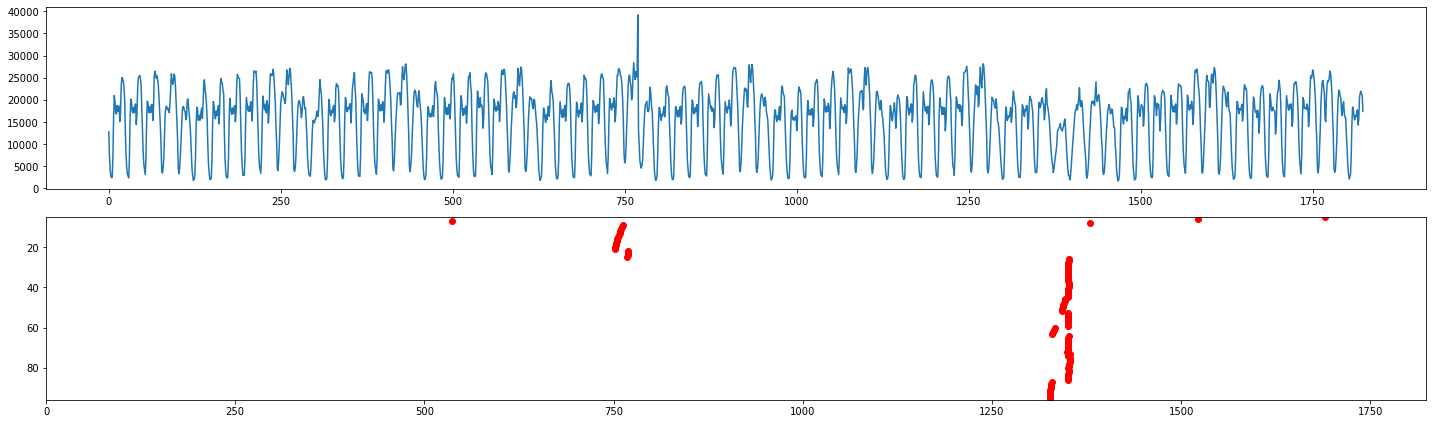

In [20]:
n_ts = len(ts)

fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(ts)

ax[1].set_xlim(left=0, right=n_ts-1) 
ax[1].set_ylim(bottom=96, top=5) 
for item in Discords:
    ax[1].scatter(x=int(item[0]), y=int(item[1]),c='r')

fig.tight_layout()
plt.show()

There are a few discords that is not "clearly" illustrated in the figure 11 of the paper. However, if we zoom in, we will notice that these points are shown (but with lower color value.) These points might be false positives as discussed by paper in some sections.

### Comparing with MATLAB (by the author)

The figure obtained by MATLAB code shown below. Some points are highlighted. These are the ones that are vaguely illustrated in Fig. 11.

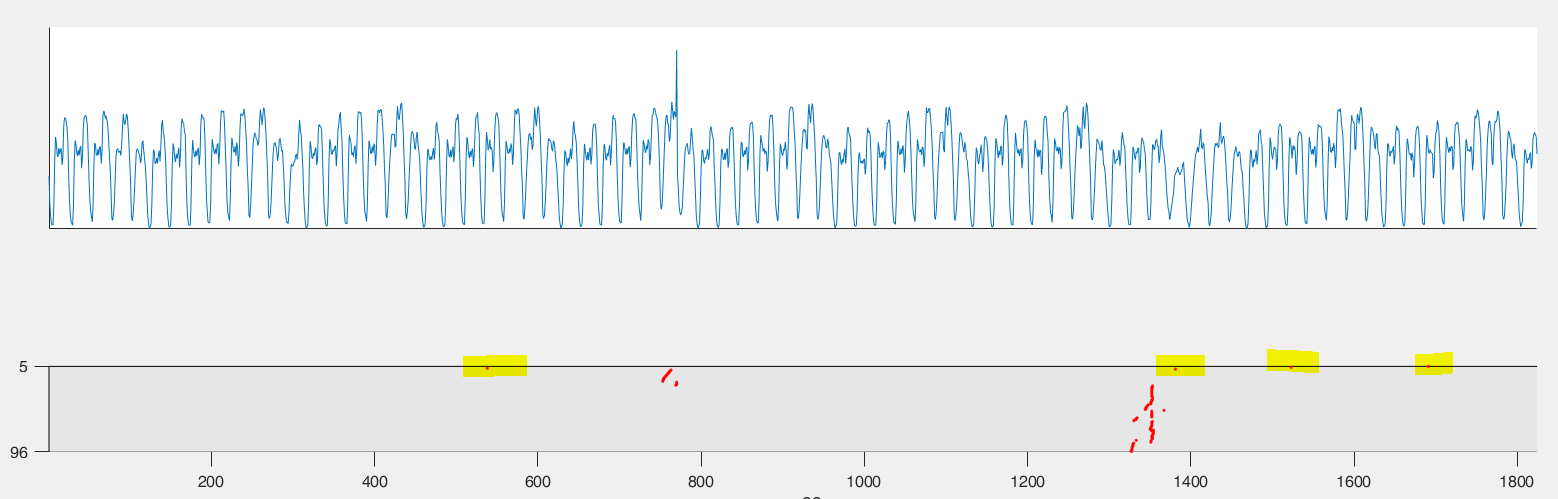



### Comparing values obainted by Python / MATLAB

In [27]:
#two files: Taxi_MATLAB_results.csv (MERLIN3), Taxi_MATLAB_results_r99percent.csv (MERLIN3 but with r=r*0.99)
Discords_by_MATLAB = pd.read_csv("MERLIN_datasets\\taxi_results_by_MATLAB\\Taxi_MATLAB_results.csv", header=None).to_numpy()


for col in range(4):
    modification_val = 0
    if ((col==0) or (col==2)):
        modification_val = 1
    
    Discords_MATLAB = Discords_by_MATLAB[:,col] #by MATLAB code
    Discords_Python = Discords[:,col] + modification_val #by Python code (but with MATLAB indexing)
    
    diff = np.abs(Discords_MATLAB - Discords_Python)
    print(f'> differece at col={col} is: \n {diff}')

> differece at col=0 is: 
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 24.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 19.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0]
> differece at col=1 is: 
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0]
> differece at col=2 is: 
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 

### plot discords that are different in MATLAB and Python

mask:  [47 79]
> Discords_by_MATLAB_only: 
 [[1367.           52.          286.            3.68959178]
 [1333.           84.          948.            5.55797485]]
>  Discords_by_Python_only: 
 [[1342.0 52.0 240.0 4.290034033714779]
 [1351.0 84.0 1519.0 5.963234981527579]]


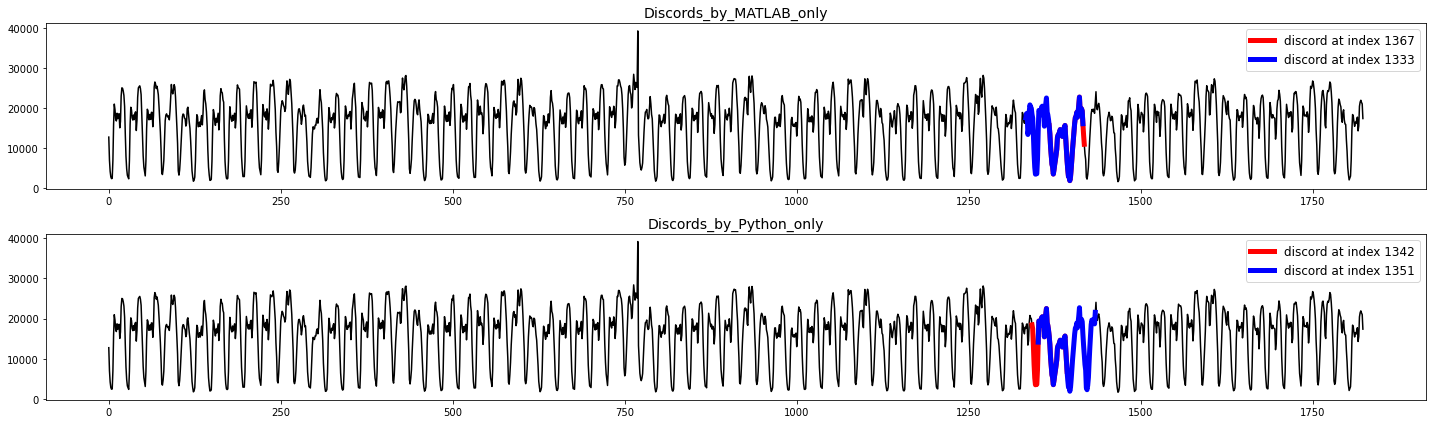

In [28]:
#finding discords that discovered by only Python (Table 3) or by only MATLAB (merlin3.m)
Discords_MATLAB = Discords_by_MATLAB[:,0] #by MATLAB code
Discords_Python = Discords[:,0] + 1 #by Python code (but with MATLAB indexing)

diff = Discords_MATLAB - Discords_Python
mask = np.where(diff != 0)[0]
print('mask: ', mask)

Discords_by_MATLAB_only = Discords_by_MATLAB[np.ix_(mask,)]
print("> Discords_by_MATLAB_only: \n", Discords_by_MATLAB_only)

Discords_by_Python_only = Discords[np.ix_(mask,)]
print(">  Discords_by_Python_only: \n", Discords_by_Python_only)

print('=======================================================================')

#plotting
n_discord = len(Discords_by_Python_only) #= len(Discords_by_MATLAB_only) = len(Discords_by_Python_only)

fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(ts, 'k')
ax[1].plot(ts , 'k')

color_vec = ['r','b','g','cyan']
for n in range(n_discord):
    idx = int(Discords_by_MATLAB_only[n][0])               
    m = int(Discords_by_MATLAB_only[n][1])
    ax[0].plot(np.arange(idx,idx+m), ts[idx:idx+m],c=color_vec[n], lw=5, label=f"discord at index {idx}")
    
    idx = int(Discords_by_Python_only[n][0])
    m = int(Discords_by_Python_only[n][1])
    ax[1].plot(np.arange(idx,idx+m), ts[idx:idx+m],c=color_vec[n], lw=5, label=f"discord at index {idx}")


ax[0].set_title("Discords_by_MATLAB_only",fontsize=14)
ax[1].set_title("Discords_by_Python_only",fontsize=14)

ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)

fig.tight_layout()
plt.show()

## Let's use MERLIN on Mars Science Laboratory data (Fig. 17)

### Fig 17 (Top)

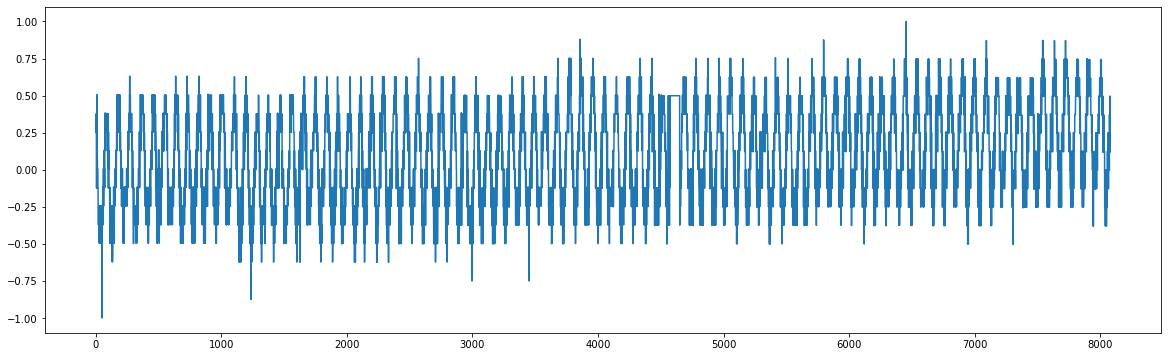

Stage#1: Calculating the first discord...
Discords after finding the first one: 
 [4621, 100, 1856, 10.157679320604531]
Stage#2: Calculating the next four discords...
>>> Discords after finding the next four discords:  [4620, 101, 1855, 10.171769398019203]
>>> Discords after finding the next four discords:  [4619, 102, 1854, 10.193542903240862]
>>> Discords after finding the next four discords:  [4618, 103, 1853, 10.208707651428835]
>>> Discords after finding the next four discords:  [4617, 104, 1852, 10.224377236546244]
Stage#3: Calculating the remaining discords...
>>> new discord:  [4616, 105, 1851, 10.242503500622734]
>>> new discord:  [4615, 106, 1850, 10.260924151058221]
>>> new discord:  [4614, 107, 1849, 10.285198260566528]
>>> new discord:  [4613, 108, 1848, 10.302661801716697]
>>> new discord:  [4612, 109, 1847, 10.322350769548644]
>>> new discord:  [4611, 110, 1846, 10.340590227889743]
>>> new discord:  [4610, 111, 1845, 10.359155157249335]
>>> new discord:  [4609, 112, 1844

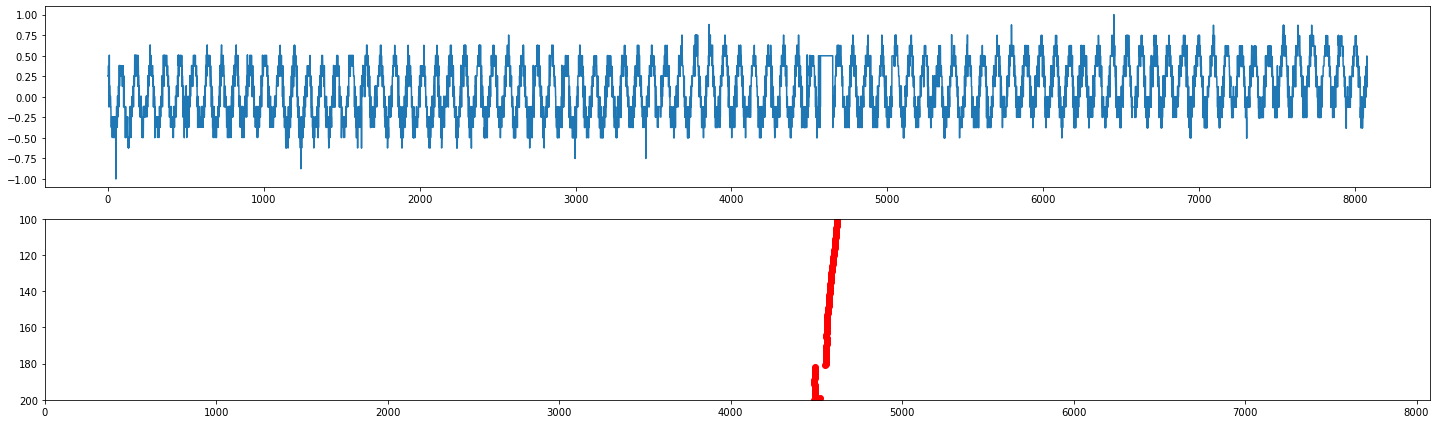

In [14]:
df_MSL_topFigure = pd.read_csv("MERLIN_datasets\\Mars Science Laboratory\\A-4.csv", header=None) 
ts = np.reshape(df_MSL_topFigure.to_numpy(), newshape = (-1, ))

#plot data
plt.plot(ts)
plt.show()

#finging discords of different length
MinL = 100; MaxL = 200;
Discords = MERLIN(ts, MinL, MaxL)
print('----------------------------')
print('Discords are: ', Discords)
print('----------------------------')


#now, let's plot the discords
n_ts = len(ts)
fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(ts)

ax[1].set_xlim(left=0, right=n_ts-1) 
ax[1].set_ylim(bottom=MaxL, top=MinL) 
for item in Discords:
    ax[1].scatter(x=int(item[0]), y=int(item[1]),c='r')

fig.tight_layout()
plt.show()

In [15]:
#let's compare it with MATLAB:
Discords_by_MATLAB = pd.read_csv("MERLIN_datasets\\MSL_A_4_results_by_MATLAB\\MSL_A_4_MATLAB_results.csv", header=None).to_numpy()


for col in range(4):
    modification_val = 0
    if ((col==0) or (col==2)):
        modification_val = 1
    
    Discords_MATLAB = Discords_by_MATLAB[:,col] #by MATLAB code
    Discords_Python = Discords[:,col] + modification_val #by Python code (but with MATLAB indexing)
    
    diff = Discords_MATLAB - Discords_Python
    print(f'> differece at col={col}: \n {diff}')
    print('------------------------------------')

> differece at col=0: 
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 2.0 0.0 0.0 0.0 -1.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 45.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
------------------------------------
> differece at col=1: 
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
------------------------------------
> differece at col=2: 
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0

In [16]:
#finding discords that discovered by only Python (Table 3) or by only MATLAB (merlin3.m)
Discords_MATLAB = Discords_by_MATLAB[:,0] #by MATLAB code
Discords_Python = Discords[:,0] + 1 #by Python code (but with MATLAB indexing)

diff = Discords_MATLAB - Discords_Python
mask = np.where(diff != 0)[0]
print('mask: ', mask)

Discords_by_MATLAB_only = Discords_by_MATLAB[np.ix_(mask,)]
print("> Discords_by_MATLAB_only: \n", Discords_by_MATLAB_only)

Discords_by_Python_only = Discords[np.ix_(mask,)]
print(">  Discords_by_Python_only: \n", Discords_by_Python_only)

mask:  [64 65 69 89]
> Discords_by_MATLAB_only: 
 [[4560.          164.         3448.           13.07258705]
 [4560.          165.         3448.           13.00654582]
 [4559.          169.         3447.           12.86713642]
 [4534.          189.         3242.           12.54498155]]
>  Discords_by_Python_only: 
 [[4558.0 164.0 1794.0 13.073851185881805]
 [4557.0 165.0 3265.0 13.013944757640772]
 [4559.0 169.0 1791.0 12.92545927998484]
 [4488.0 189.0 4940.0 12.725059358431976]]


### Fig 17 (Bottom)

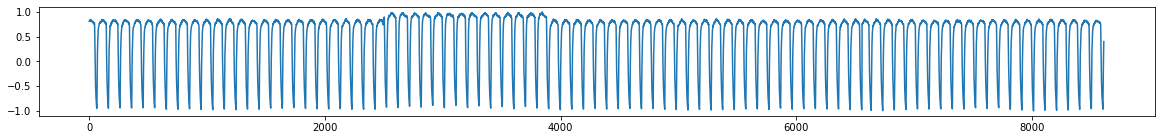

Stage#1: Calculating the first discord...
Discords after finding the first one: 
 [2452, 50, 6513, 6.988589716525622]
Stage#2: Calculating the next four discords...
>>> Discords after finding the next four discords:  [2455, 51, 6516, 7.21034079543704]
>>> Discords after finding the next four discords:  [2454, 52, 6515, 7.3796824145701265]
>>> Discords after finding the next four discords:  [2453, 53, 6514, 7.653534419834977]
>>> Discords after finding the next four discords:  [2452, 54, 6513, 7.864855363689324]
Stage#3: Calculating the remaining discords...
>>> new discord:  [2451, 55, 6512, 8.098133947700275]
>>> new discord:  [2450, 56, 3025, 7.981972696303882]
>>> new discord:  [2449, 57, 8527, 8.063921231460577]
>>> new discord:  [2448, 58, 3023, 7.853800659646501]
>>> new discord:  [2447, 59, 3022, 7.742214310284297]
>>> new discord:  [2446, 60, 8524, 7.646865919342419]
>>> new discord:  [2445, 61, 8523, 7.495948336002726]
>>> new discord:  [2444, 62, 8522, 7.132423463703552]
>>> 

>>> new discord:  [6459, 194, 8218, 13.034678109083059]
>>> new discord:  [6459, 195, 8218, 13.092185101044661]
>>> new discord:  [6458, 196, 8216, 13.183138973382674]
>>> new discord:  [6458, 197, 8216, 13.242060076101428]
>>> new discord:  [6458, 198, 8216, 13.291416221047605]
>>> new discord:  [6458, 199, 8217, 13.329938988865312]
>>> new discord:  [6458, 200, 8217, 13.36279103835696]
>>> new discord:  [6457, 201, 8213, 13.410035736173581]
>>> new discord:  [6457, 202, 8214, 13.450329899173258]
>>> new discord:  [6457, 203, 8215, 13.480367752115198]
>>> new discord:  [6457, 204, 8215, 13.508163751453068]
>>> new discord:  [6457, 205, 8215, 13.535970829715493]
>>> new discord:  [6457, 206, 8215, 13.562534002739897]
>>> new discord:  [6457, 207, 8215, 13.58831923577682]
>>> new discord:  [6457, 208, 8215, 13.613733358880088]
>>> new discord:  [6457, 209, 8215, 13.638538826234344]
>>> new discord:  [6457, 210, 8215, 13.66172002556634]
>>> new discord:  [6457, 211, 8215, 13.685795980662

>>> new discord:  [6415, 341, 2294, 16.861476076173364]
>>> new discord:  [6413, 342, 2292, 16.877204118694255]
>>> new discord:  [6413, 343, 2292, 16.892975803442756]
>>> new discord:  [6413, 344, 2292, 16.90813021312782]
>>> new discord:  [6413, 345, 2292, 16.92368031359006]
>>> new discord:  [6413, 346, 2292, 16.93836060643106]
>>> new discord:  [6411, 347, 2290, 16.953636007986056]
>>> new discord:  [6411, 348, 2290, 16.96834501387713]
>>> new discord:  [6411, 349, 2290, 16.98327047907773]
>>> new discord:  [6411, 350, 2290, 16.99820027418349]
>>> new discord:  [6411, 351, 2290, 17.012675597318633]
>>> new discord:  [6408, 352, 2287, 17.02728837245877]
>>> new discord:  [6405, 353, 2284, 17.04242583890579]
>>> new discord:  [6404, 354, 2283, 17.057768876746664]
>>> new discord:  [6404, 355, 2283, 17.072572227614536]
>>> new discord:  [6402, 356, 2281, 17.087985734138396]
>>> new discord:  [6399, 357, 2278, 17.103199956937875]
>>> new discord:  [6400, 358, 2279, 17.11860253472269]
>

>>> new discord:  [6338, 489, 2213, 19.868673062240656]
>>> new discord:  [6338, 490, 2214, 19.909058797770758]
>>> new discord:  [6337, 491, 2213, 19.953655587109044]
>>> new discord:  [6336, 492, 2211, 19.987828510869488]
>>> new discord:  [6335, 493, 2210, 20.004419255909585]
>>> new discord:  [6335, 494, 2211, 20.02218789813033]
>>> new discord:  [6334, 495, 2210, 20.03865342935066]
>>> new discord:  [6333, 496, 2209, 20.05499717119008]
>>> new discord:  [6332, 497, 2208, 20.071006975682156]
>>> new discord:  [6331, 498, 2207, 20.08690362679942]
>>> new discord:  [6330, 499, 2206, 20.102727027693405]
>>> new discord:  [6329, 500, 2205, 20.11835952568508]
----------------------------
Discords are:  [[2452.0 50.0 6513.0 6.988589716525622]
 [2455.0 51.0 6516.0 7.21034079543704]
 [2454.0 52.0 6515.0 7.3796824145701265]
 ...
 [6331.0 498.0 2207.0 20.08690362679942]
 [6330.0 499.0 2206.0 20.102727027693405]
 [6329.0 500.0 2205.0 20.11835952568508]]
----------------------------


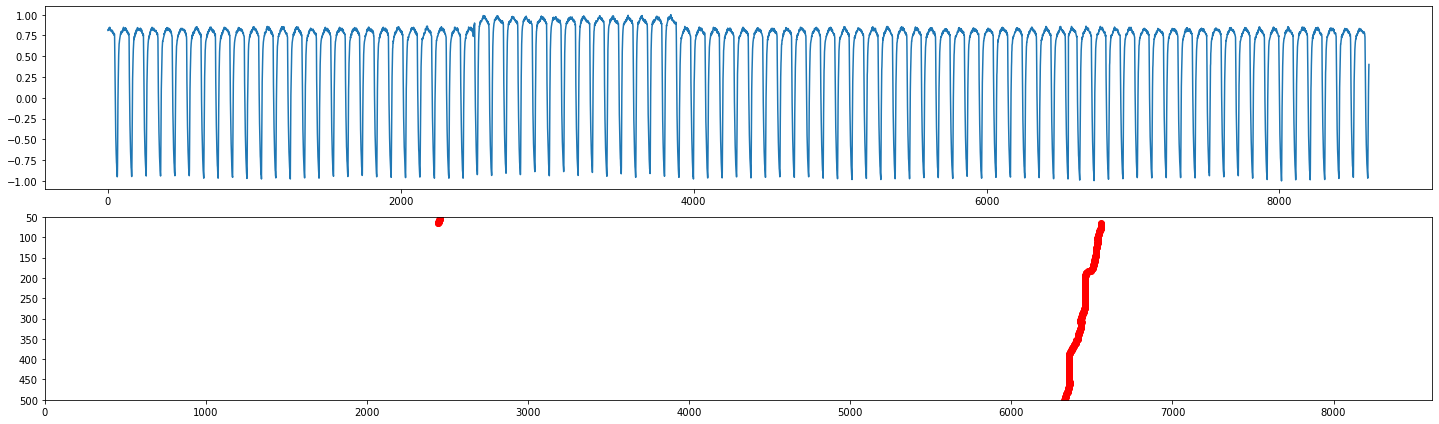

In [50]:
df_MSL_topFigure = pd.read_csv("MERLIN_datasets\\Mars Science Laboratory\\T-1.csv", header=None) 
ts = np.reshape(df_MSL_topFigure.to_numpy(), newshape = (-1, ))

#plot data
plt.figure(figsize=(20,2))
plt.plot(ts)
plt.show()

#finging discords of different length
MinL = 50; MaxL = 500;
Discords = MERLIN(ts, MinL, MaxL)
print('----------------------------')
print('Discords are: ', Discords)
print('----------------------------')


#now, let's plot the discords
n_ts = len(ts)
fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(ts)

ax[1].set_xlim(left=0, right=n_ts-1) 
ax[1].set_ylim(bottom=MaxL, top=MinL) 
for item in Discords:
    ax[1].scatter(x=int(item[0]), y=int(item[1]),c='r')

fig.tight_layout()
plt.show()